In [2]:
from functools import partial
import matplotlib.pyplot as plt

# from readTFRecords import *

# import tensorflow_hub as hub
# from tensorflow.keras.applications import MobileNet

import tensorflow as tf
from tensorflow import keras
import re
import numpy as np
import pandas as pd

from functools import partial

IMAGE_SIZE = (380, 380)
AUTOTUNE = tf.data.experimental.AUTOTUNE
CLASSES = ['0', '1', '2', '3', '4']
NUM_CLASSES = len(CLASSES)

def read_tfrecord(example, labeled=True):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64)
    }

    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = decode_image(example["image"])
    
    if labeled:
        label = tf.cast(example["target"], tf.int32)
        return image, label
    return image

def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32)# / 255.0
#     image = tf.cast(image, tf.int32)
    return image
    
    
    
def load_dataset(filenames, labeled=True):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False  # disable order, increase speed
    dataset = tf.data.TFRecordDataset(
        filenames
    )  # automatically interleaves reads from multiple files
    dataset = dataset.with_options(
        ignore_order
    )  # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(partial(read_tfrecord, labeled=True), num_parallel_calls=AUTOTUNE)
    # returns a dataset of (image, label) pairs if labeled=True or just images if labeled=False
    return dataset

# One-hot / categorical encoding
# Resize
def input_preprocess(image, label):
    image = tf.image.resize(image, size=IMAGE_SIZE)
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

def get_training_dataset(FILENAMES, BATCH_SIZE=12):
    dataset = load_dataset(FILENAMES, labeled=True)  
    dataset = dataset.map(input_preprocess, num_parallel_calls=AUTOTUNE)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
#     dataset = dataset.map(cutmix)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

def get_validation_dataset(FILENAMES, BATCH_SIZE=12):
    dataset = load_dataset(FILENAMES, labeled=True)
    dataset = dataset.map(input_preprocess, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset



from sklearn.model_selection import train_test_split

# AUTOTUNE = tf.data.experimental.AUTOTUNE
GCS_PATH = "../input/train_tfrecords"

FILENAMES = tf.io.gfile.glob(GCS_PATH + "/*tfrec")
split_ind = int(0.9 * len(FILENAMES))
# TRAINING_FILENAMES, VALID_FILENAMES = FILENAMES[:split_ind], FILENAMES[split_ind:]

TRAINING_FILENAMES, VALID_FILENAMES = train_test_split(FILENAMES, test_size=0.2, random_state=420)

print(TRAINING_FILENAMES)
print(VALID_FILENAMES)

TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + "../input/test_tfrecords/*tfrec")
print("Train TFRecord Files:", len(TRAINING_FILENAMES))
print("Validation TFRecord Files:", len(VALID_FILENAMES))
print("Test TFRecord Files:", len(TEST_FILENAMES))

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALID_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)

print('Dataset: {} training images, {} validation images, {} (unlabeled) test images'.format(
    NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

['../input/train_tfrecords/ld_train07-1338.tfrec', '../input/train_tfrecords/ld_train13-1338.tfrec', '../input/train_tfrecords/ld_train15-1327.tfrec', '../input/train_tfrecords/ld_train10-1338.tfrec', '../input/train_tfrecords/ld_train02-1338.tfrec', '../input/train_tfrecords/ld_train00-1338.tfrec', '../input/train_tfrecords/ld_train04-1338.tfrec', '../input/train_tfrecords/ld_train01-1338.tfrec', '../input/train_tfrecords/ld_train14-1338.tfrec', '../input/train_tfrecords/ld_train08-1338.tfrec', '../input/train_tfrecords/ld_train11-1338.tfrec', '../input/train_tfrecords/ld_train09-1338.tfrec']
['../input/train_tfrecords/ld_train05-1338.tfrec', '../input/train_tfrecords/ld_train03-1338.tfrec', '../input/train_tfrecords/ld_train12-1338.tfrec', '../input/train_tfrecords/ld_train06-1338.tfrec']
Train TFRecord Files: 12
Validation TFRecord Files: 4
Test TFRecord Files: 0
Dataset: 16045 training images, 5352 validation images, 0.0 (unlabeled) test images


In [4]:
import efficientnet.keras as eff
from tensorflow.keras.experimental import CosineDecay

In [5]:
BATCH_SIZE = 8
epochs = 12

decay_steps = int(round(NUM_TRAINING_IMAGES/BATCH_SIZE))*epochs
cosine_decay = CosineDecay(initial_learning_rate=1e-4, decay_steps=decay_steps, alpha=0.3)

from keras.backend import sigmoid

class SwishActivation(tf.keras.layers.Activation):
    
    def __init__(self, activation, **kwargs):
        super(SwishActivation, self).__init__(activation, **kwargs)
        self.__name__ = 'swish_act'

def swish_act(x, beta = 1):
    return (x * sigmoid(beta * x))

from keras.utils.generic_utils import get_custom_objects
# from tf.keras.layers import Activation
get_custom_objects().update({'swish_act': SwishActivation(swish_act)})

data_augmentation_layers = tf.keras.Sequential(
    [
#         tf.keras.layers.experimental.preprocessing.RandomCrop(height=512, width=512),
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.25),
        tf.keras.layers.experimental.preprocessing.RandomContrast((0.2,0.2)),
        tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=0.4, width_factor=0.3)
    ], 
    name="img_augmentation"
)

def buildModel():
    inputs = tf.keras.layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    x = data_augmentation_layers(inputs)
    # model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")
    model = eff.EfficientNetB4(include_top=False, input_tensor=x, weights='noisy-student')


    # Freeze the pretrained weights
    # model.trainable = False

    # Rebuild top
    x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = tf.keras.layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    x = tf.keras.layers.Dense(512)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(swish_act)(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    x = tf.keras.layers.Dense(256)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(swish_act)(x)

    outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    
    return model

In [6]:
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALID_FILENAMES)

train_dataset = get_training_dataset(TRAINING_FILENAMES, BATCH_SIZE)
valid_dataset = get_validation_dataset(VALID_FILENAMES, BATCH_SIZE)

STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
VALID_STEPS = NUM_VALIDATION_IMAGES // BATCH_SIZE

In [7]:
decay_steps = int(round(NUM_TRAINING_IMAGES/BATCH_SIZE))*epochs
cosine_decay = CosineDecay(initial_learning_rate=1e-4, decay_steps=decay_steps, alpha=0.3)
    
model = buildModel()

checkpoint = tf.keras.callbacks.ModelCheckpoint("EfficientNet_B4.ckpt", 
                                            monitor='val_accuracy', 
                                            verbose=1,
                                            save_best_only=True, 
                                            mode='max', save_freq='epoch',
                                           save_weights_only=True)

# callbacks = [ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(cosine_decay), 
              metrics=["accuracy"])

In [8]:
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 380, 380, 3) 0                                            
__________________________________________________________________________________________________
img_augmentation (Sequential)   (None, 380, 380, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 190, 190, 48) 1296        img_augmentation[0][0]           
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 190, 190, 48) 192         stem_conv[0][0]                  
_______________________________________________________________________________________

In [7]:
for image,l in train_dataset.take(1):
    print(image.shape)

(8, 380, 380, 3)


In [8]:
aug_img = data_augmentation_layers(image)

In [9]:
# for i in range(BATCH_SIZE):
#     plt.imshow(aug_img[i]/255.0)
#     plt.show()

In [10]:
history = model.fit(train_dataset, 
                    steps_per_epoch=STEPS_PER_EPOCH, 
                    epochs=25,
                    validation_data=valid_dataset,
                    validation_steps=VALID_STEPS, 
                   callbacks=[checkpoint])

Epoch 1/25
2005/2005 [==============================] - 907s 444ms/step - loss: 1.0799 - accuracy: 0.5925 - val_loss: 0.5356 - val_accuracy: 0.8126

Epoch 00001: val_accuracy improved from -inf to 0.81259, saving model to EfficientNet_B4.ckpt
Epoch 2/25
2005/2005 [==============================] - 883s 440ms/step - loss: 0.6318 - accuracy: 0.7765 - val_loss: 0.4846 - val_accuracy: 0.8266

Epoch 00002: val_accuracy improved from 0.81259 to 0.82661, saving model to EfficientNet_B4.ckpt
Epoch 3/25
2005/2005 [==============================] - 882s 440ms/step - loss: 0.5731 - accuracy: 0.7987 - val_loss: 0.4210 - val_accuracy: 0.8518

Epoch 00003: val_accuracy improved from 0.82661 to 0.85183, saving model to EfficientNet_B4.ckpt
Epoch 4/25
2005/2005 [==============================] - 884s 441ms/step - loss: 0.5333 - accuracy: 0.8148 - val_loss: 0.4093 - val_accuracy: 0.8580

Epoch 00004: val_accuracy improved from 0.85183 to 0.85800, saving model to EfficientNet_B4.ckpt
Epoch 5/25
2005/200

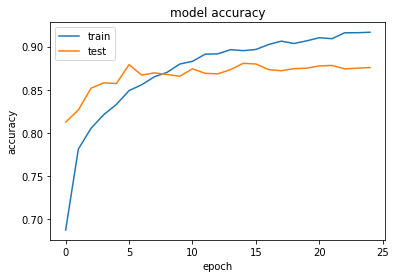

In [11]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [9]:
eb4_1 = tf.keras.models.load_model('/home/usmanr/Downloads/EfficientNet_B4_1.h5')
eb4_2 = tf.keras.models.load_model('/home/usmanr/Downloads/EfficientNet_B4_2.h5')
eb4_3 = tf.keras.models.load_model('/home/usmanr/Downloads/EfficientNet_B4_3.h5')

In [10]:
eb4_1.save_weights('EfficientNet_B4_1_tpu.ckpt')
eb4_2.save_weights('EfficientNet_B4_2_tpu.ckpt')
eb4_3.save_weights('EfficientNet_B4_3_tpu.ckpt')

In [84]:
NUM_VALIDATION_IMAGES//8

669

In [92]:
VALID_STEPS*8

5352

In [86]:
preds = []
labels = []

for i, data in enumerate(valid_dataset.as_numpy_iterator()):
    pred = [[0,0,0,0,0]]*BATCH_SIZE
    labels += [np.argmax(d) for d in data[1]]
    image = data[0]

    pred+=eb0.predict(image)
#     if i % 100 == 0:print(i)
    print(i*BATCH_SIZE)
    preds+=[np.argmax(p) for p in pred]
    if i>VALID_STEPS:break

0
8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
304
312
320
328
336
344
352
360
368
376
384
392
400
408
416
424
432
440
448
456
464
472
480
488
496
504
512
520
528
536
544
552
560
568
576
584
592
600
608
616
624
632
640
648
656
664
672
680
688
696
704
712
720
728
736
744
752
760
768
776
784
792
800
808
816
824
832
840
848
856
864
872
880
888
896
904
912
920
928
936
944
952
960
968
976
984
992
1000
1008
1016
1024
1032
1040
1048
1056
1064
1072
1080
1088
1096
1104
1112
1120
1128
1136
1144
1152
1160
1168
1176
1184
1192
1200
1208
1216
1224
1232
1240
1248
1256
1264
1272
1280
1288
1296
1304
1312
1320
1328
1336
1344
1352
1360
1368
1376
1384
1392
1400
1408
1416
1424
1432
1440
1448
1456
1464
1472
1480
1488
1496
1504
1512
1520
1528
1536
1544
1552
1560
1568
1576
1584
1592
1600
1608
1616
1624
1632
1640
1648
1656
1664
1672
1680
1688
1696
1704
1712
1720
1728
1736
1744
1752
1760
1768
1776
1784
1792
1800
1808
1816


In [60]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [87]:
accuracy_score(labels, preds)

0.882660687593423

In [91]:
len(preds)

5352

In [89]:
confusion_matrix(labels, preds)

array([[ 214,   13,    9,   10,   46],
       [  28,  430,   18,   27,   57],
       [   8,   14,  479,   44,   44],
       [  11,   20,   84, 3125,   36],
       [  53,   30,   41,   35,  476]])

In [63]:
for image, label in valid_dataset.take(1):
    print(image.shape)

(8, 380, 380, 3)


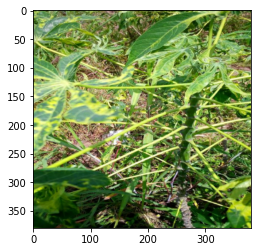

In [65]:
plt.imshow(image[0]/255.0)

In [88]:
VALID_FILENAMES

['../input/train_tfrecords/ld_train05-1338.tfrec',
 '../input/train_tfrecords/ld_train03-1338.tfrec',
 '../input/train_tfrecords/ld_train12-1338.tfrec',
 '../input/train_tfrecords/ld_train06-1338.tfrec']

In [ ]:
['../input/train_tfrecords/ld_train05-1338.tfrec',
 '../input/train_tfrecords/ld_train01-1338.tfrec',
 '../input/train_tfrecords//ld_train07-1338.tfrec',
 '../input/train_tfrecords/ld_train02-1338.tfrec',
 '../input/train_tfrecords/ld_train10-1338.tfrec',
 '../input/train_tfrecords/ld_train15-1327.tfrec']